<a href="https://colab.research.google.com/github/batuhanbaydr/DSA210-Term-Project/blob/main/notebooks/Phase2_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
%cd /content
!git clone -q https://github.com/batuhanbaydr/DSA210-Term-Project.git proj
%cd proj
!pip -q install pandas seaborn matplotlib pyarrow

import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
sns.set_theme()
df = pd.read_parquet("data/processed/oscars_plus_bechdel_pol.parquet")
print("Rows:", len(df))


/content
fatal: destination path 'proj' already exists and is not an empty directory.
/content/proj
Rows: 10856


### Nominees per decade

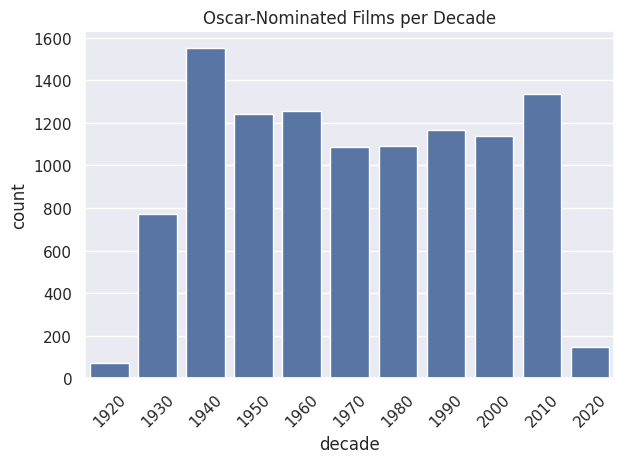

In [31]:
df["decade"] = (df["year_ceremony"] // 10) * 10
sns.countplot(x="decade", data=df, order=sorted(df["decade"].unique()))
plt.title("Oscar-Nominated Films per Decade")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()


### 2. Bechdel pass & Political-theme trends

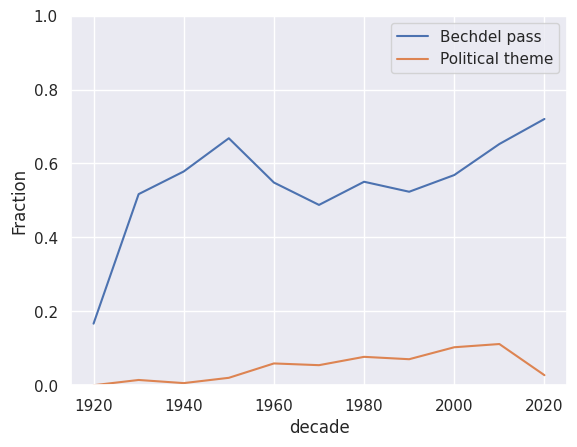

In [41]:
bech = df.dropna(subset=["bechdel_pass"]).groupby("decade")["bechdel_pass"].mean()
pol  = df.groupby("decade")["political_theme"].mean()
bech.plot(label="Bechdel pass"); pol.plot(label="Political theme")
plt.ylim(0,1); plt.ylabel("Fraction"); plt.legend(); plt.show()

### 3. Win-rate bars

<ipython-input-42-8b91818b5f53>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_plot["bechdel_pass"] = df_plot["bechdel_pass"].fillna(False).astype(bool).astype(str)


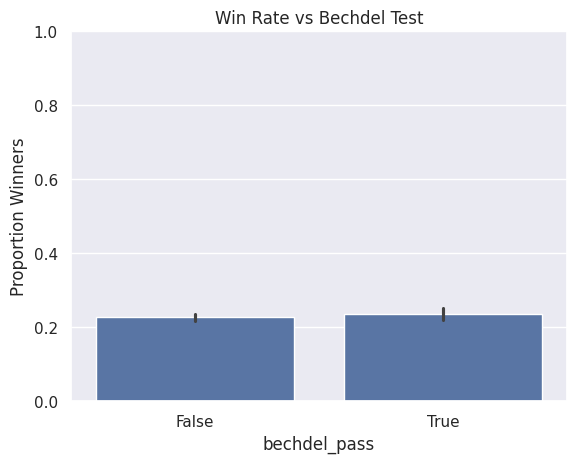

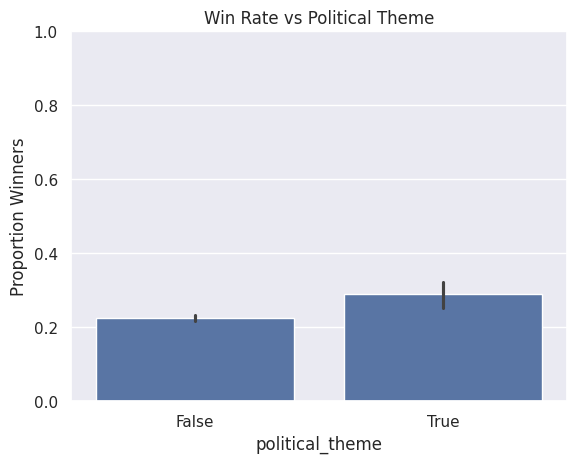

In [42]:
df_plot = df.copy()

df_plot["bechdel_pass"] = df_plot["bechdel_pass"].fillna(False).astype(bool).astype(str)
df_plot["political_theme"] = df_plot["political_theme"].astype(str)

for col, title in [("bechdel_pass", "Bechdel Test"),
                   ("political_theme", "Political Theme")]:
    sns.barplot(x=col, y="winner", data=df_plot, estimator="mean")
    plt.ylim(0, 1)
    plt.ylabel("Proportion Winners"); plt.title(f"Win Rate vs {title}")
    plt.show()


## 4. Chi-Square Tests  
*Printed tables & p-values used in the report.*

In [43]:
def show_chi2(tbl, name):
    chi2, p, _, _ = chi2_contingency(tbl)
    print(f"\n{name}\n", tbl, f"\nχ² = {chi2:.2f} | p = {p:.4g}")

# 4.1 Bechdel × Winner
tbl1 = pd.crosstab(df["winner"], df["bechdel_pass"].fillna(False))
show_chi2(tbl1, "Bechdel pass × Winner")

# 4.2 Political × Winner
tbl2 = pd.crosstab(df["winner"], df["political_theme"])
show_chi2(tbl2, "Political theme × Winner")

# 4.3 Racial shift — nominees
df["Race_s"] = df["Race"].fillna("Unknown").str.strip()
keep = ["White","Black","Asian","Hispanic","Unknown"]
df["Race_s"] = df["Race_s"].where(df["Race_s"].isin(keep), "Other")
pre_nom  = df[df["year_ceremony"] <  2000]["Race_s"]
post_nom = df[df["year_ceremony"] >= 2000]["Race_s"]
tbl3 = pd.crosstab(["pre"]*len(pre_nom) + ["2000+"]*len(post_nom),
                   pd.concat([pre_nom, post_nom], ignore_index=True))
show_chi2(tbl3, "Race (Nominees) pre-2000 vs 2000+")

# 4.4 Racial shift — winners
pre_w  = df[(df["winner"]) & (df["year_ceremony"] < 2000)]["Race_s"]
post_w = df[(df["winner"]) & (df["winner"]) & (df["year_ceremony"] >= 2000)]["Race_s"]
tbl4 = pd.crosstab(["pre"]*len(pre_w) + ["2000+"]*len(post_w),
                   pd.concat([pre_w, post_w], ignore_index=True))
show_chi2(tbl4, "Race (Winners) pre-2000 vs 2000+")


Bechdel pass × Winner
 bechdel_pass  False  True 
winner                    
False          6438   1944
True           1879    595 
χ² = 0.74 | p = 0.3907

Political theme × Winner
 political_theme  False  True 
winner                       
False             7945    437
True              2297    177 
χ² = 13.12 | p = 0.0002916

Race (Nominees) pre-2000 vs 2000+
 Race_s  Asian  Black  Hispanic  White
row_0                                
2000+     130    107         9   2375
pre       108     86        17   8024 
χ² = 235.16 | p = 1.059e-50

Race (Winners) pre-2000 vs 2000+
 Race_s  Asian  Black  Hispanic  White
row_0                                
2000+      31     36         6    515
pre        21     17         3   1845 
χ² = 107.99 | p = 2.971e-23


<ipython-input-43-8db598463ca3>:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tbl1 = pd.crosstab(df["winner"], df["bechdel_pass"].fillna(False))


### Conclusions
* *Political-theme films win significantly more often (p ≈ 2.9 × 10⁻⁴).*
* *Bechdel pass does **not** correlate with winning (p ≈ 0.39).*
* *Racial composition of both nominees and winners changed significantly after 2000 (p ≈ 10⁻⁵⁰ and 10⁻²³).*